In [20]:
# Importing necessary lebraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as pl
pl.ioff()
import seaborn as se
from collections import Counter
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
sys.path.append(os.path.join(os.path.abspath('..')))
# Import modules
from src import data_loading as dl

In [3]:

sys.path.append(os.path.abspath("../"))


from scripts.model import prepare_data, split_data

from scripts.logger import logger 

In [4]:

fraud_df = dl.load_data("processed/processed_fraud_data.csv")
credit_df = dl.load_data("creditcard.csv")

In [5]:
print('No frauds', round(fraud_df['class'].value_counts()[0]/len(fraud_df) * 100,2),
      '% of the dataset')
print('Frauds', round(fraud_df['class'].value_counts()[1]/len(fraud_df) * 100,2),
      '% of the dataset')

No frauds 90.64 % of the dataset
Frauds 9.36 % of the dataset


 dataset - it's  skewed toNo frauds transactions! i want  my model to be vigilant and identify subtle patterns that indicate potential fraud. To achieve this, we must address the class imbalance issue head-on

Feature and Target Separation for Fraud_Data.csv

In [6]:

X_fraud, y_fraud = prepare_data(fraud_df, 'class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: class


2025-02-08 13:59:08,105 - INFO - Preparing data by separating features and target column: class


Train-Test Split for Fraud_Data.csv

In [7]:

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = split_data(X_fraud, y_fraud)

INFO:fraud_detection_logger:Splitting data into train and test sets


2025-02-08 13:59:10,539 - INFO - Splitting data into train and test sets


In [8]:
print("Fraud Data Shapes:")
print("X_train_fraud:", X_train_fraud.shape)
print("X_test_fraud:", X_test_fraud.shape)
print("y_train_fraud:", y_train_fraud.shape)
print("y_test_fraud:", y_test_fraud.shape)

Fraud Data Shapes:
X_train_fraud: (120889, 21)
X_test_fraud: (30223, 21)
y_train_fraud: (120889,)
y_test_fraud: (30223,)


In [9]:
# Check the distribution of labels in the training and testing sets
train_unique_label, train_counts_label = np.unique(y_train_fraud, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test_fraud, return_counts=True)


print('Label Distributions: \n')
print('Training set label distribution:', train_counts_label/ len(y_train_fraud))
print('Testing set label distribution:', test_counts_label/ len(y_test_fraud))

Label Distributions: 

Training set label distribution: [0.90651755 0.09348245]
Testing set label distribution: [0.90570096 0.09429904]


In [10]:
non_fraud_sum = fraud_df[fraud_df['class'] == 0].value_counts().sum()
print('non fraud data ', non_fraud_sum)

non fraud data  136961


In [11]:
fraud_sum = fraud_df[fraud_df['class'] == 1].value_counts().sum()
print(' fraud data ', fraud_sum)

 fraud data  14151


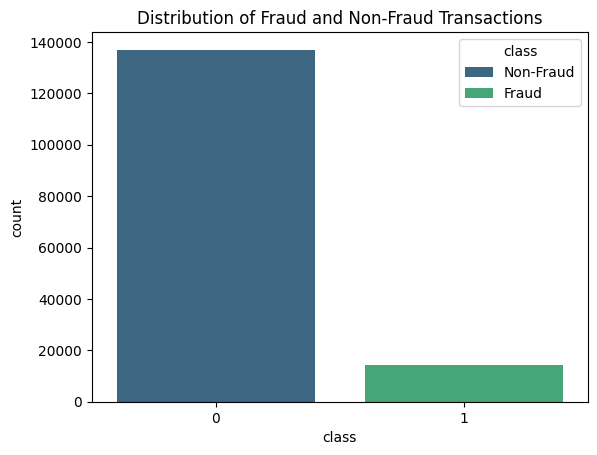

In [12]:
se.countplot(data=fraud_df, x='class', hue='class', palette='viridis')
pl.legend(title='class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

In [13]:
# To address the class imbalance issue, we'll undersample the majority class
# to match the number of instances in the minority class.

# Randomly shuffle the entire dataset to ensure randomness
df = fraud_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Isolate the minority class (fraud) with 12,268 instances
minority_class = df.loc[df['class'] == 1]

# Select a random subset of the majority class (non-fraud) with the same number of instances as the minority class
majority_class_subset = df.loc[df['class'] == 0].sample(n=12268, random_state=42)

# Combine the minority class and the majority class subset to create a balanced dataset
balanced_df = pd.concat([minority_class, majority_class_subset])

# Shuffle the balanced dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df = balanced_df.drop(columns=['Unnamed: 0', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])
bool_cols = balanced_df.select_dtypes(include=['bool']).columns
balanced_df[bool_cols] = balanced_df[bool_cols].astype(int)
# Verify the first few rows of the balanced dataset
balanced_df.head()

,user_id,purchase_value,age,class,hour_of_day,day_of_week,purchase_delay,user_transaction_frequency,device_transaction_frequency,user_transaction_velocity,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,266960,0.440144,-1.408809,1,0.358542,1.489476,1.633176,0.0,-0.261514,-0.230129,0,1,0,0,1,0,0
1,8233,-0.487667,-1.640890,0,-1.666788,-1.002803,0.178339,0.0,-0.261514,-0.230128,0,1,0,0,0,0,0
2,60532,0.549298,1.608235,1,0.069209,-1.501259,0.290011,0.0,-0.261514,-0.230128,0,0,0,0,0,0,0
3,1925,-1.197169,1.492195,0,-0.364790,-1.501259,0.207138,0.0,-0.261514,-0.230128,1,0,0,1,0,0,1
4,336948,0.003527,-1.524850,1,-0.075457,0.492565,-1.577617,0.0,3.559736,4.345476,0,1,1,0,0,0,1


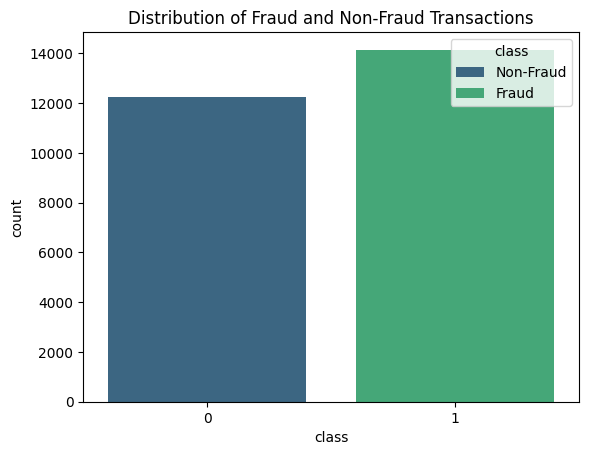

In [14]:
se.countplot(data=balanced_df, x='class', hue='class', palette='viridis')
pl.legend(title='class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

In [15]:

X_fraud, y_fraud = prepare_data(balanced_df, 'class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: class


2025-02-08 13:59:36,466 - INFO - Preparing data by separating features and target column: class


In [16]:
X_train = X_train_fraud.values
X_test = X_test_fraud.values
y_train = y_train_fraud.values
X_test = X_test_fraud.values
y_test = y_test_fraud.values

In [17]:

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = split_data(X_fraud, y_fraud)

INFO:fraud_detection_logger:Splitting data into train and test sets


2025-02-08 13:59:41,313 - INFO - Splitting data into train and test sets


In [18]:
X_train_fraud = X_train_fraud.astype('float64')
X_test_fraud = X_test_fraud.astype('float64')


In [23]:
# Train and evaluate Logistic Regression model for Fraud_Data.csv
with mlflow.start_run(run_name="Logistic Regression - Fraud Data"):
    logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')  # Increased max_iter & balanced class weights
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')

    logistic_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = logistic_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(logistic_model, "logistic_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Logistic Regression - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))

c:\Users\HP\Documents\Dagii\week 8 --9\fraud-detection-models\week-8\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logistic Regression - Fraud Data:
               precision    recall  f1-score   support

           0       0.68      0.98      0.81      2483
           1       0.97      0.60      0.74      2801

    accuracy                           0.78      5284
   macro avg       0.83      0.79      0.77      5284
weighted avg       0.84      0.78      0.77      5284



In [26]:
# Train and evaluate Decision Tree model for Fraud_Data.csv
with mlflow.start_run(run_name="Decision Tree - Fraud Data"):
    decision_tree_model = DecisionTreeClassifier()
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')
    
    # Convert integer columns in X_test_fraud to float64 to avoid schema enforcement warnings
    X_test_fraud = X_test_fraud.astype('float64')
    
    decision_tree_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = decision_tree_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Decision Tree")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(decision_tree_model, "decision_tree_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Decision Tree - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))


c:\Users\HP\Documents\Dagii\week 8 --9\fraud-detection-models\week-8\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Decision Tree - Fraud Data:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      2483
           1       0.73      0.74      0.74      2801

    accuracy                           0.72      5284
   macro avg       0.72      0.72      0.72      5284
weighted avg       0.72      0.72      0.72      5284



In [21]:
# Train and evaluate Random Forest model for Fraud_Data.csv
with mlflow.start_run(run_name="Random Forest - Fraud Data"):
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train_fraud = X_train_fraud.astype('float64')
    X_test_fraud = X_test_fraud.astype('float64')

    random_forest_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = random_forest_model.predict(X_test_fraud)

    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(random_forest_model, "random_forest_model_fraud", input_example=X_test_fraud[:5])

    # Print classification report
    print("Random Forest - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))


c:\Users\HP\Documents\Dagii\week 8 --9\fraud-detection-models\week-8\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Random Forest - Fraud Data:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      2483
           1       0.93      0.71      0.80      2801

    accuracy                           0.82      5284
   macro avg       0.83      0.82      0.82      5284
weighted avg       0.84      0.82      0.82      5284



In [20]:
duplicate_count = credit_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 1081


In [21]:
# Remove duplicates in the credit card data
credit_df = credit_df.drop_duplicates()
duplicate_count = credit_df.duplicated().sum()
print(f"Number of duplicate rows after drop duplicate : {duplicate_count}")

Number of duplicate rows after drop duplicate : 0


 Feature and Target Separation for creditcard.csv

In [23]:
X_credit, y_credit = prepare_data(credit_df, 'Class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: Class


2025-02-07 17:27:28,260 - INFO - Preparing data by separating features and target column: Class


Train-Test Split for creditcard.csv

In [24]:

X_train_credit, X_test_credit, y_train_credit, y_test_credit = split_data(X_credit, y_credit)

INFO:fraud_detection_logger:Splitting data into train and test sets


2025-02-07 17:27:31,077 - INFO - Splitting data into train and test sets


In [27]:
print("Credit Card Data Shapes:")
print("X_train_credit:", X_train_credit.shape)
print("X_test_credit:", X_test_credit.shape)
print("y_train_credit:", y_train_credit.shape)
print("y_test_credit:", y_test_credit.shape)

Credit Card Data Shapes:
X_train_credit: (226980, 30)
X_test_credit: (56746, 30)
y_train_credit: (226980,)
y_test_credit: (56746,)


Set the tracking URI to the local server (ensure MLflow tracking server is running)

Train and evaluate Logistic Regression model for creditcard.csv

In [29]:
# Train and evaluate Logistic Regression model for creditcard.csv
with mlflow.start_run(run_name="Logistic Regression - Credit Card Data"):
    logistic_model = LogisticRegression(max_iter=200)  # Increased max_iter
    logistic_model.fit(X_train_credit, y_train_credit)
    y_pred_credit = logistic_model.predict(X_test_credit)
    
    # Generate classification report
    report_credit = classification_report(y_test_credit, y_pred_credit, output_dict=True)
    accuracy_credit = report_credit['accuracy']
    
    # Log parameters, metrics, and model
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_credit)
    mlflow.sklearn.log_model(logistic_model, "logistic_model_credit")
    
    # Print classification report
    print("Logistic Regression - Credit Card Data:\n", classification_report(y_test_credit, y_pred_credit))

c:\Users\HP\Documents\Dagii\week 8 --9\fraud-detection-models\week-8\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/02/07 17:28:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - Credit Card Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.76      0.63      0.69        90

    accuracy                           1.00     56746
   macro avg       0.88      0.82      0.85     56746
weighted avg       1.00      1.00      1.00     56746

🏃 View run Logistic Regression - Credit Card Data at: http://localhost:5000/#/experiments/0/runs/a4f2cd67e6b142f68d0ec4414de7cd16
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [30]:
# Train and evaluate Logistic Regression model for Fraud_Data.csv
with mlflow.start_run(run_name="Logistic Regression - Fraud Data"):
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train_fraud, y_train_fraud)
    y_pred_fraud = logistic_model.predict(X_test_fraud)
    
    # Generate classification report
    report_fraud = classification_report(y_test_fraud, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']
    
    # Log parameters, metrics, and model
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(logistic_model, "logistic_model_fraud")
    
    # Print classification report
    print("Logistic Regression - Fraud Data:\n", classification_report(y_test_fraud, y_pred_fraud))

🏃 View run Logistic Regression - Fraud Data at: http://localhost:5000/#/experiments/0/runs/565b3c32d7b74f8ca21208827f1677f9
🧪 View experiment at: http://localhost:5000/#/experiments/0


TypeError: Cannot cast DatetimeArray to dtype float64